# Exercise 9: Sentiment Classification with an MLP

In this notebook, we will:
1. Load and inspect the IMDB sentiment dataset (train/test) provided in the local `aclImdb/` directory.
2. Preprocess texts and extract features (e.g., TF-IDF).
3. Define an MLP classifier with dropout for regularization.
4. Train and evaluate the model.

We structure the code using Python classes, each explained in the Markdown cells that precede them.



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as api
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [22]:
# Function to download Large Movie Review Dataset
def download_movie_reviews_dataset():
    """Download and prepare the IMDB Large Movie Review Dataset."""
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    # Download the dataset
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)

    # Extract the tar.gz file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())

    # Extract the tar file
    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()

    # Clean up
    os.remove('aclImdb_v1.tar')

    # Load the dataset
    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews

    # Load positive and negative reviews from both train and test sets
    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')

    # Combine all data
    all_data = positive_train + negative_train + positive_test + negative_test

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])

    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

df = download_movie_reviews_dataset()


Dataset loaded! Total samples: 50000


In [23]:
df

,text,sentiment
0,Just finished this impressively nutty affair a...,positive
1,All I can say about the Necromaniac/Schizophre...,positive
2,One of the best love stories I have ever seen....,positive
3,"The story-line of ""The Thief of Bagdad"" is com...",positive
4,The cover case and the premise that write ther...,negative
...,...,...
49995,The scenes are fast-paced. the characters are ...,positive
49996,"In ""Red Letters"", Coyote is at the vortex of a...",negative
49997,"Some weeks ago, at a movie theater, I saw a mo...",negative
49998,Why this movie has all but disappeared into ob...,positive


In [24]:
# First, split into training and temp (which will be further split into dev and test)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Print the sizes to verify the split
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 35000
Test set size: 15000


In [17]:
def tokenize(data):
  stop_words = stopwords.words('english')
  stop_words.extend(string.punctuation)
  stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
  tokenized_samples = []
  for sample in data:
    tokens = []
    # Split text into sentences
    sentences = sent_tokenize(sample)
    for sent in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sent)
        for word in words:
            # Filter out stopwords and unwanted tokens
            if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                continue
            if word.strip():
                # Process the token and add to list
                tokens.append(word.replace('"', "'").strip().lower())
    tokenized_samples.append(tokens)

  return tokenized_samples

In [50]:
def preprocess_data(train_data, test_data,
                   representation='bow',
                   features_number=2000,
                   reduce_features=False,
                   reduced_features_number=None):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'],
        test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

     # Convert string labels to integers
    # Create a mapping of labels to indices
    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels using the mapping
    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    if representation == "tfidf":
        vectorizer = TfidfVectorizer(max_features=features_number,
                                    sublinear_tf=True)
        X_train = vectorizer.fit_transform(
            [" ".join(x) for x in X_train_tokenized]
        ).toarray()
        X_val = vectorizer.transform(
            [" ".join(x) for x in X_val_tokenized]
        ).toarray()
        X_test = vectorizer.transform(
            [" ".join(x) for x in X_test_tokenized]
        ).toarray()

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)

    elif representation == "embeddings":
        word_vectors = api.load("word2vec-google-news-300")
        X_train, X_val, X_test = [], [], []

        for doc in X_train_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_train.append(centroid)
        X_train = np.array(X_train, dtype=np.float32)  # Explicitly set dtype

        for doc in X_val_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_val.append(centroid)
        X_val = np.array(X_val, dtype=np.float32)  # Explicitly set dtype

        for doc in X_test_tokenized:
            embeddings = [word_vectors[word]
                         for word in doc if word in word_vectors]
            if embeddings:
                centroid = np.mean(embeddings, axis=0)
            else:
                centroid = np.zeros(word_vectors.vector_size)
            X_test.append(centroid)
        X_test = np.array(X_test, dtype=np.float32)  # Explicitly set dtype

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)

    else:  # "bow" case
        vectorizer = CountVectorizer(max_features=features_number)
        X_train = vectorizer.fit_transform(
            [" ".join(x) for x in X_train_tokenized]
        ).toarray()
        X_val = vectorizer.transform(
            [" ".join(x) for x in X_val_tokenized]
        ).toarray()
        X_test = vectorizer.transform(
            [" ".join(x) for x in X_test_tokenized]
        ).toarray()

        if reduce_features:
            assert reduced_features_number is not None
            svd = TruncatedSVD(n_components=reduced_features_number,
                              random_state=42)
            X_train = svd.fit_transform(X_train)
            X_val = svd.transform(X_val)
            X_test = svd.transform(X_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [38]:
# 2. Define a single parameterized model class
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_layers=None,
                 dropout=0.0, batch_norm=False, layer_norm=False,
                 classes_number=20):
        super(CustomModel, self).__init__()
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, classes_number))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [39]:
# 3. Train and evaluate models
def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=20):
    train_losses, val_losses = [], []
    best_val_loss = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if epoch % 5 == 0:
            print(f'Epoch: {epoch:4.0f} / {epochs} | Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}')

        # You can add Early Stopping here...

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

          # Delete the previous best model if it exists
          if best_model_path is not None:
              os.remove(best_model_path)

          # Save the new best model
          torch.save(model.state_dict(), new_model_path)
          best_model_path = new_model_path  # Update the best model path

          # load model later with model.load_state_dict(torch.load(path))

    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            preds = torch.argmax(preds, dim=1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

Label mapping: {'negative': 0, 'positive': 1}
Training Linear (BoW)...
Epoch:    0 / 20 | Training Loss: 0.47555, Validation Loss: 0.39035
Epoch:    5 / 20 | Training Loss: 0.26897, Validation Loss: 0.30944
Epoch:   10 / 20 | Training Loss: 0.24995, Validation Loss: 0.31368
Epoch:   15 / 20 | Training Loss: 0.24281, Validation Loss: 0.32185
Training Plain MLP (BoW)...
Epoch:    0 / 20 | Training Loss: 0.37363, Validation Loss: 0.32509
Epoch:    5 / 20 | Training Loss: 0.02782, Validation Loss: 0.57161
Epoch:   10 / 20 | Training Loss: 0.00031, Validation Loss: 1.03333
Epoch:   15 / 20 | Training Loss: 0.00005, Validation Loss: 1.22600
Training MLP with Dropout (BoW)...
Epoch:    0 / 20 | Training Loss: 0.41019, Validation Loss: 0.30468
Epoch:    5 / 20 | Training Loss: 0.12263, Validation Loss: 0.38545
Epoch:   10 / 20 | Training Loss: 0.05850, Validation Loss: 0.56623
Epoch:   15 / 20 | Training Loss: 0.03792, Validation Loss: 0.60213
Training MLP with BatchNorm (BoW)...
Epoch:    0 /

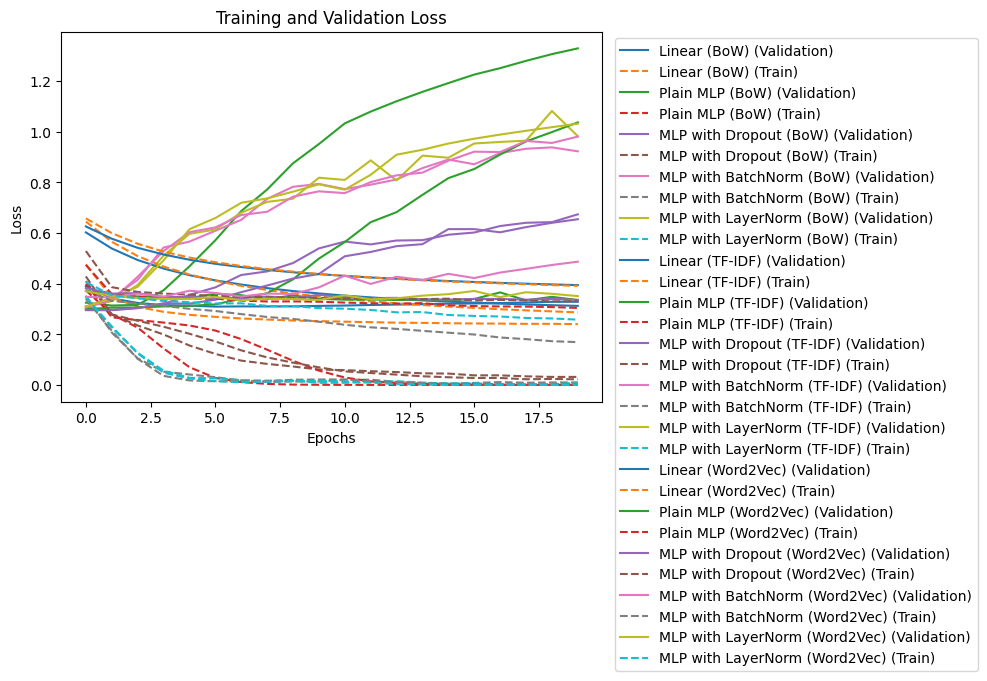


Linear (BoW) Metrics:
Accuracy: 0.8704
Precision: 0.8705
Recall: 0.8704
F1 Score: 0.8704

Plain MLP (BoW) Metrics:
Accuracy: 0.8553
Precision: 0.8554
Recall: 0.8553
F1 Score: 0.8553

MLP with Dropout (BoW) Metrics:
Accuracy: 0.8641
Precision: 0.8642
Recall: 0.8641
F1 Score: 0.8641

MLP with BatchNorm (BoW) Metrics:
Accuracy: 0.8531
Precision: 0.8536
Recall: 0.8531
F1 Score: 0.8531

MLP with LayerNorm (BoW) Metrics:
Accuracy: 0.8545
Precision: 0.8555
Recall: 0.8545
F1 Score: 0.8544

Linear (TF-IDF) Metrics:
Accuracy: 0.8765
Precision: 0.8768
Recall: 0.8765
F1 Score: 0.8764

Plain MLP (TF-IDF) Metrics:
Accuracy: 0.8587
Precision: 0.8590
Recall: 0.8587
F1 Score: 0.8587

MLP with Dropout (TF-IDF) Metrics:
Accuracy: 0.8683
Precision: 0.8683
Recall: 0.8683
F1 Score: 0.8683

MLP with BatchNorm (TF-IDF) Metrics:
Accuracy: 0.8541
Precision: 0.8544
Recall: 0.8541
F1 Score: 0.8541

MLP with LayerNorm (TF-IDF) Metrics:
Accuracy: 0.8562
Precision: 0.8562
Recall: 0.8562
F1 Score: 0.8562

Linear (Wo

In [51]:
# Main script
representations = {"BoW": "bow", "TF-IDF": "tfidf", "Word2Vec": "embeddings"}
models_config = {
    "Linear": [],
    "Plain MLP": [128, 64],
    "MLP with Dropout": [128, 64],
    "MLP with BatchNorm": [128, 64],
    "MLP with LayerNorm": [128, 64]
}

results = {}
epochs = 20  # adjust according to preference...
batch_size = 128

for rep_name, rep_type in representations.items():
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data(train_data, test_data, representation=rep_type)
    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                                  torch.LongTensor(y_train).to(device))
    val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device),
                                torch.LongTensor(y_val).to(device))
    test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device),
                                 torch.LongTensor(y_test).to(device))

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    input_dim = X_train.shape[1]

    for model_name, hidden_layers in models_config.items():
        model_key = f"{model_name} ({rep_name})"
        model = CustomModel(input_dim, hidden_layers=hidden_layers,
                            dropout=0.5 if "Dropout" in model_name else 0.0,
                            batch_norm="BatchNorm" in model_name,
                            layer_norm="LayerNorm" in model_name,
                            classes_number=len(np.unique(y_train))
                            ).float().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        print(f"Training {model_key}...")
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
        results[model_key] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "metrics": evaluate_model(model, test_loader)
        }


# Plot losses
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result["val_losses"], label=f"{name} (Validation)")
    plt.plot(result["train_losses"], linestyle='--', label=f"{name} (Train)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print metrics
for name, result in results.items():
    accuracy, precision, recall, f1 = result["metrics"]
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")